# Прогнозирование зарплат в России

Импортируем нужные пакеты и создаём функцию invboxocox.  

In [101]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [105]:
print (sm.__version__)

0.10.1


Импортируем датасет

In [174]:
df = pd.read_csv('C:\\Users\\khvorova_ee\\OneDrive - АО «АЛЕРС РУС»\\Coursera\\WAG_C_M.csv', sep=';', header=None,index_col=[0],parse_dates=[0], dayfirst=False)
df=df[1:]
df.columns=['salary']
df['salary']=pd.to_numeric(df['salary'])
df.index=pd.to_datetime(df.index).strftime("%Y-%d-%m")
df.head()

,salary
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


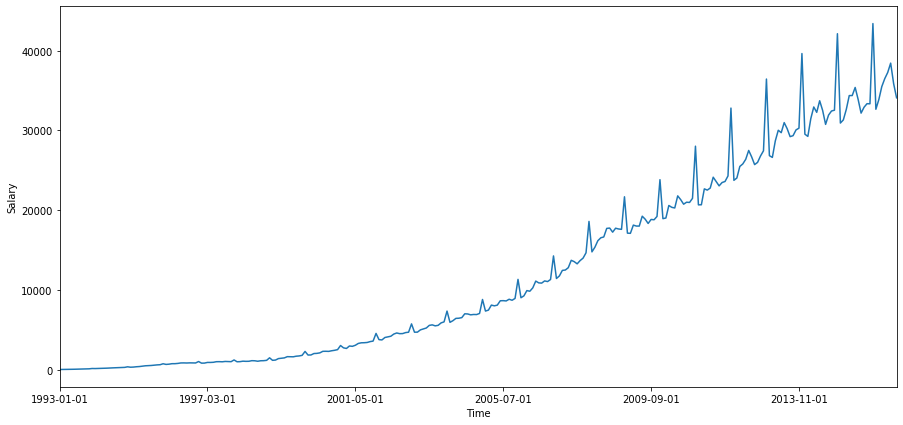

In [175]:
plt.figure(figsize(15,7))
df.salary.plot()
plt.ylabel('Salary')
plt.xlabel('Time')
pylab.show()

Проверим данные на стационарность и посмотрим STL-разложение

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

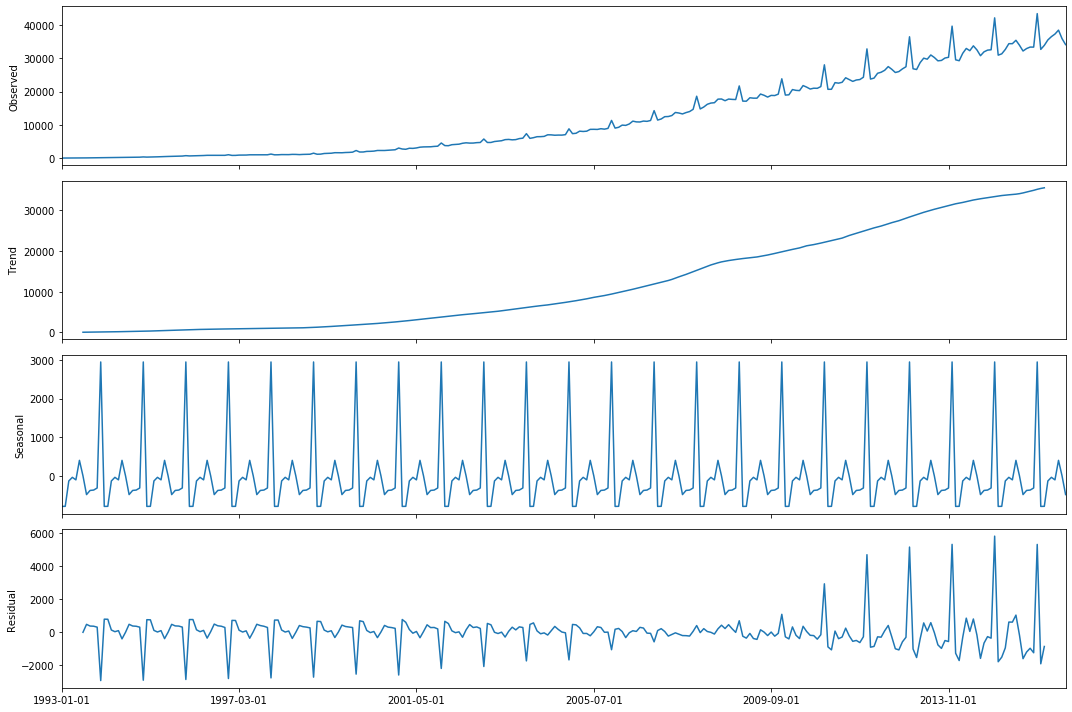

In [176]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary,freq=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary)[1])

Видим повышающийся тренд, очевидную сезонность, а также нестационарность в остатках. Сделаем преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


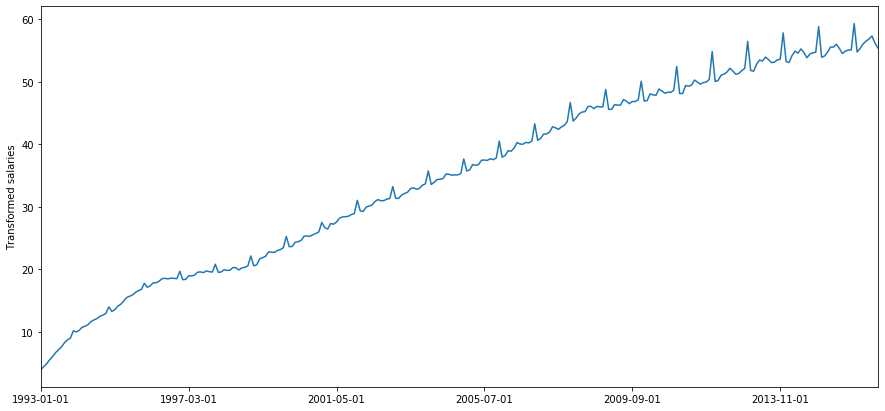

In [177]:
df['salary_boxcox'], lmbda = stats.boxcox(df.salary)
plt.figure(figsize(15,7))
df.salary_boxcox.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_boxcox)[1])

Сделаем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

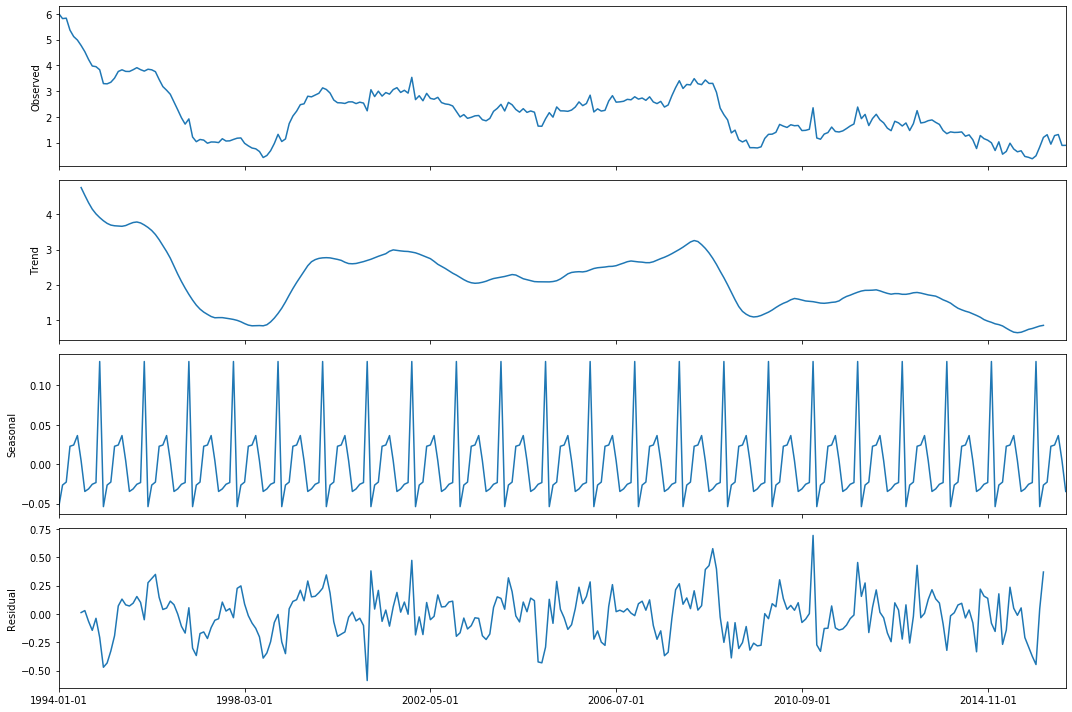

In [178]:
df['salary_bc_diff'] = df.salary_boxcox -df.salary_boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_bc_diff[12:], freq=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_bc_diff[12:])[1])

Критерий показывает, что получился стационарный ряд, но мы видим, что тренд все ещё есть. Сделаем обычное дифференцирование. 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

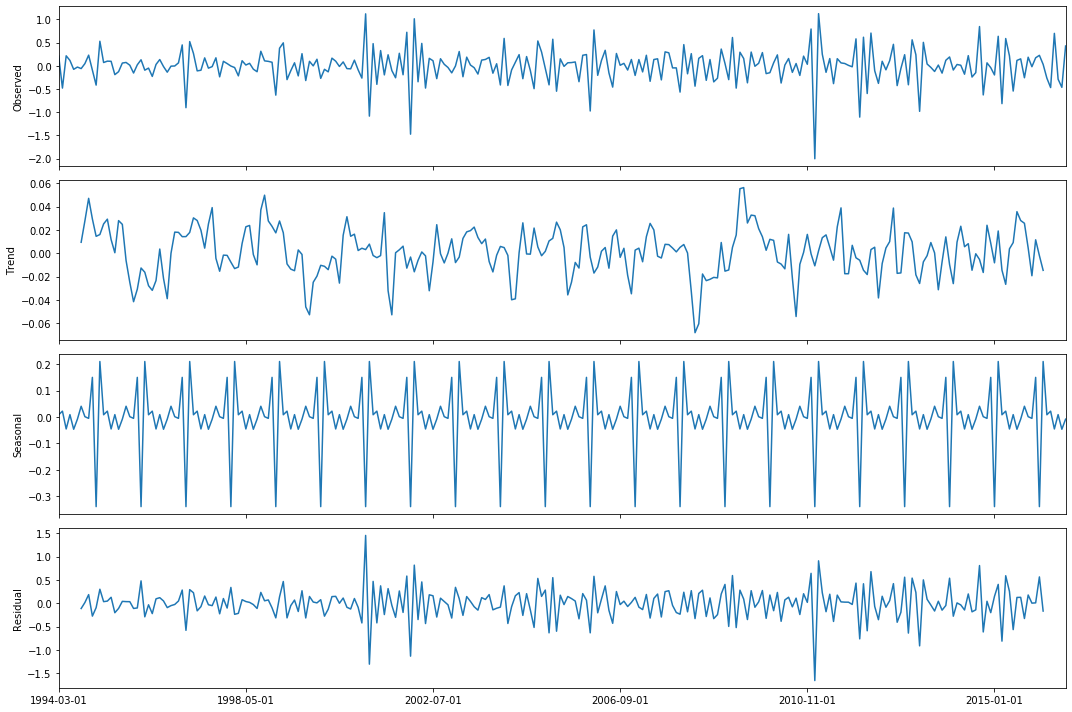

In [183]:
df['salary_bc_diff2'] = df.salary_bc_diff - df.salary_bc_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_bc_diff2[14:], freq=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_bc_diff2[14:])[1])

Теперь мы избавились от тренда и можно переходить к выбору модели. Строим автокорреляционную и частичную автокорреляционную функцию.

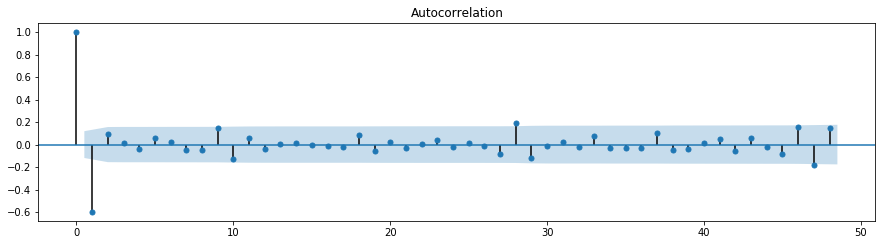

C:\Users\khvorova_ee\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


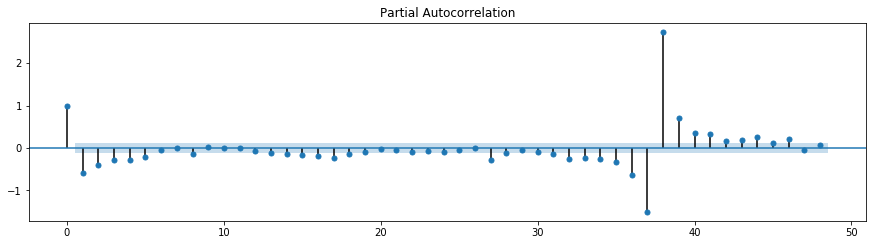

In [184]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salary_bc_diff2[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salary_bc_diff2[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=4, p=5

In [185]:
ps = range(0, 5)
d=1
qs = range(0, 1)
Ps = range(0, 4)
D=1
Qs = range(0,1)

In [186]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [187]:
import statsmodels.api as sm

In [188]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.salary_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),initialization='approximate_diffuse').fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 23.1 s


In [189]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
12  (3, 0, 0, 0)  1.647764
4   (1, 0, 0, 0)  2.625709
16  (4, 0, 0, 0)  2.848800
8   (2, 0, 0, 0)  3.031513
0   (0, 0, 0, 0)  5.241225


Лучшая модель имеет 3 параметра.

In [190]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      salary_boxcox   No. Observations:                  284
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   3.176
Date:                            Sun, 19 Jul 2020   AIC                              1.648
Time:                                    21:37:05   BIC                             16.056
Sample:                                01-01-1993   HQIC                             7.433
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1296      0.047     -2.749      0.006      -0.222      -0.037
ar.L2          0.0936      0.067   

Критерий Стьюдента: p=0.218665
Критерий Дики-Фуллера: p=0.000000


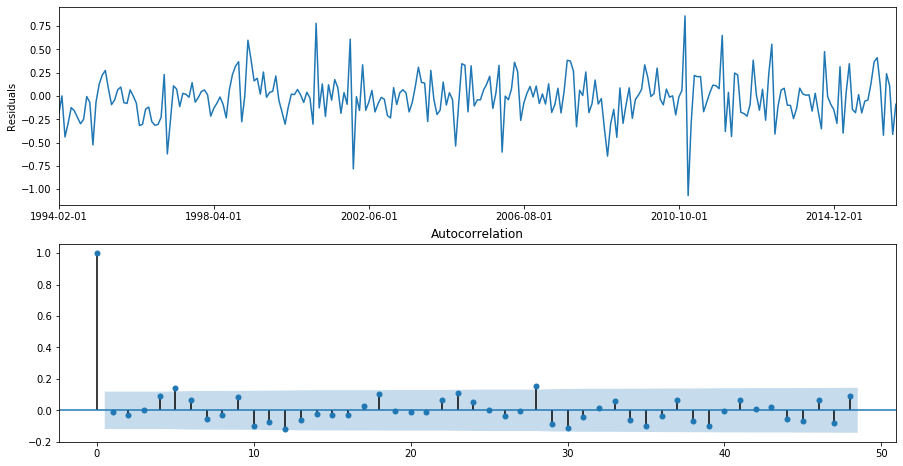

In [191]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены и стационарны.

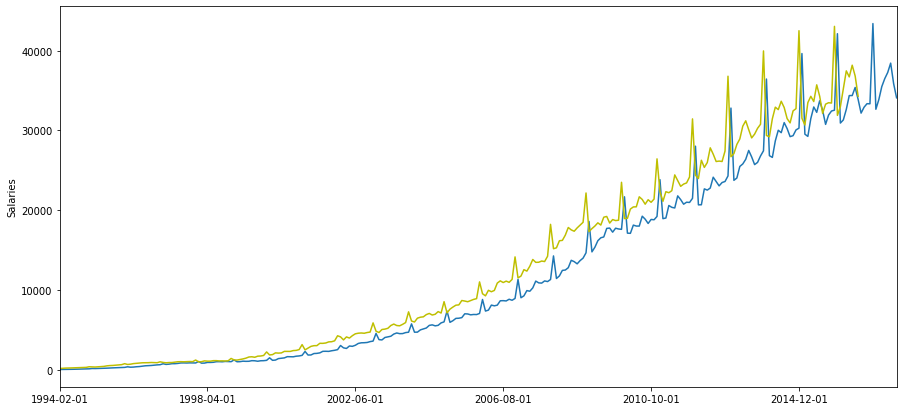

In [192]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.salary.plot()
df.model[13:].plot(color='y')
plt.ylabel('Salaries')
pylab.show()

Модель хорошо описывает данные, особенно в начале и конце ряда.

Строим прогноз на следующие 2 года

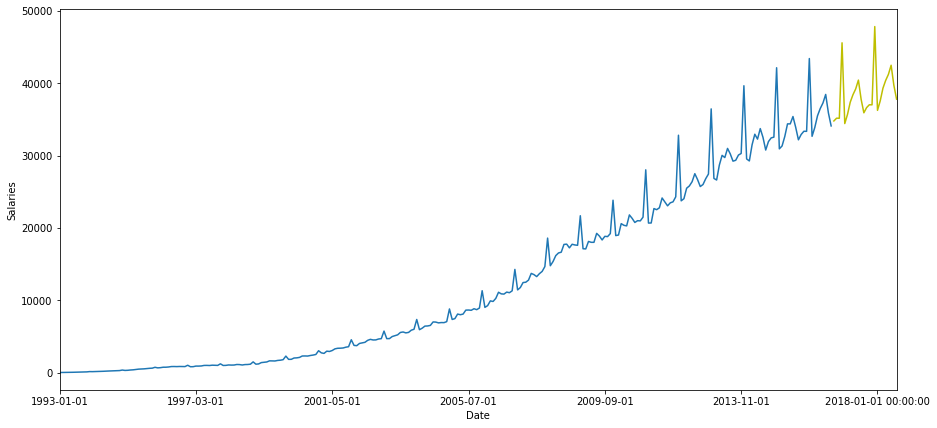

In [194]:
df2 = df[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=311), lmbda)

plt.figure(figsize(15,7))
df2.salary.plot()
df2.forecast.plot(color='y')
plt.ylabel('Salaries')
plt.xlabel('Date')
pylab.show()